# 1. Packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML packages
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# 2. Functions


In [2]:
# Remove outliers
def outliers(data,column ,outliers):

    # Soting from low to high
    outliers.sort(key = lambda x: x, reverse = False)

    # Calc IQR
    IQR = np.percentile(data[column],outliers)

    # Calc IQR size
    IQR_size = IQR[1] - IQR[0]

    # Return data without outliers
    return data[(data[column] > IQR[0] - IQR_size * 1.5) & (data[column] < IQR[1] + IQR_size * 1.5)]



# Machine learning functions

def clean_data(data):

    # Replace -9 with NaN
    data.replace(-9,np.nan,inplace = True)

    # Drop NaNs 
    data.dropna(inplace = True)

    # Change ca and thal from float to int
    data["ca"] = data["ca"].astype(int)
    data["thal"] = data["thal"].astype(int)

    # Replace 1,2,3,4 with 1 in target column
    data["target"].replace([1,2,3,4],1, inplace = True)

def discretize(data, column, threshold):

    # Set all values that are greater than or 
    # equal to the threshold to 1
    mask = data[column] >= threshold
    data.loc[mask,column] = 1

    # Set all values that are smaller than  
    # the threshold to 0
    mask = data[column] < threshold
    data.loc[mask,column] = 0

    # Change type from float to int
    data[column] =  data[column].astype(int)

def max_HR_percent(data, percent = 0.85):

    # Ensure percent is less than 1 (0.85 ---> 85%)
    if percent > 1:
        percent = percent / 100
    
    # Create new column Maximum Heart Rate Percent
    # 0 - greater than percent value, 1 less than 
    hr_percent =  [0 if patient["thalach"] / (220 - patient["age"]) >= percent 
                   else 1
                   for index,patient  in data.iterrows()]

    # Insert new column to dataset
    data["MHRPercent"] = hr_percent

## Heatmap
# For spearman make method = 'pearson'
def heatmap_cor(dataset,plot_title, method = 'spearman'):
    cor = dataset.corr(method = method)
    plt.figure(figsize = (12,8))
    plt.title(plot_title)
    sns.heatmap(cor, annot = True, cmap = 'rocket')

## Random Forest
# dataframe
def run_random_forest(x_train,x_test,y_train,y_test, estimator = 10):
    model = RandomForestClassifier(n_estimators=estimator); 
    model.fit(x_train,y_train)
    return model,x_test,y_test

## Confusion Matrix
def plot_confusion_matrix(y_test,x_pred,plot_title):
    con_matrix = confusion_matrix(y_test,x_pred)
    plt.figure(figsize = (12,8))
    sns.heatmap(con_matrix, annot = True, cmap = 'rocket')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(plot_title)

def ml_train_test_split(x,y,size = 0.20,rs = 42):
    x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = size, random_state=rs);
    return x_train,x_test,y_train,y_test

# 3. Read Dataset

In [3]:
dataset = pd.read_csv("./data/heart_disease_uci.csv", sep = ",", header = 0)
dataset.head()

# DF of Heart Disease and healthy
heart_disease = dataset[dataset["target"] > 0]
healthy = dataset[dataset["target"] == 0]

In [4]:
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


**Columns Description**
1. Age - Age of patient in years (Integer)
1. Sex - Gender of patient (1 = male, 0 = female)
1. cp - Chest pain type:
    1. Value 1: Typical Angina 
    1. Value 2: Atypical Angina
    1. Value 3: Non-Anginal Pain
    1. Value 4: Asymptomatic
1. trestbps - Resting blood pressure (in mm/Hg on admission to hospital) ( Ideal Value - 120/80 ) <br>
 People with heart disease usually have higher blood pressure because of the vessels being blocked
1. chol - Serum cholesterol in mg/dl 
1. fbs - Fasting blood sugar > 120 mg/dl <br> (1 = true, 0 = false)
1. restecg - Resting electrocardiographic results: 
    1. Value 0: normal 
    1. Value 1: Having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) - tells the provider that the patient might have a stroke
    1. Value 2: Showing probable or definite left ventricular hypertrophy by Estes' criteria
1. thalach - Maximum heart rate achieved
1. exang - Exercise Induced Angina (1 - yes, 0 = no)
1. oldpeak - ST depression induced by exercise relative to rest 
1. slope - The slope of the peak exercise ST segment:
    1. Value 1: Upsloping 
    1. Value 2: Flat
    1. Value 3: Downsloping
1. ca - Number of major vessels (0-3) colored by flourosopy
1. thal - Has three values: 
    1. Value 3: Normal 
    1. Value 6: Fixed Defect
    1. Value 7: Reverseable Defect 
1. target - Diagnosis of Heart Disease (Angiographic Disease Status)
    1. Value 0: Healthy
    1. Value 1,2,3,4: Heart Disease

# 4. Exploratory Data Analysis


## Spearman Correlation
The following spearman rank-order correlation table showing whether an association exists between two variables. Our data is ordinal, interval and monotonic since as one variable increases the other variables tend to increase or decrease. The correlation coefficient is between +1 and -1. A positive relationship (+1) depicts while one variable increases, the other variable also increases. A negative relationship (-1) depicts while one variable increases, the other tends to decrease. There is a positive correlation between restecg and slope (ST segment) which is a significant indicator of heart disease. There is also a positive correlation between exercised induced angina and slope (ST segment) which may not be a significant indicator of heart disease in healthy patients.


In [5]:
dataset.corr(method = "spearman")

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.099627,0.127748,0.292183,0.191253,0.110688,0.147927,-0.391633,0.084286,0.259895,0.176386,0.389599,0.131993,0.241696
sex,-0.099627,1.000000,0.042222,-0.060905,-0.154403,0.047862,0.021528,-0.045542,0.146201,0.108838,0.032229,0.083979,0.371411,0.257866
cp,0.127748,0.042222,1.000000,0.001771,0.075466,-0.044496,0.096271,-0.375564,0.432136,0.246493,0.207511,0.260711,0.299802,0.486933
trestbps,0.292183,-0.060905,0.001771,1.000000,0.135837,0.150812,0.142866,-0.040401,0.050861,0.150192,0.083565,0.071277,0.108006,0.137164
chol,0.191253,-0.154403,0.075466,0.135837,1.000000,0.014219,0.170718,-0.038301,0.085118,0.034359,0.002703,0.151791,0.020247,0.109293
fbs,0.110688,0.047862,-0.044496,0.150812,0.014219,1.000000,0.069510,-0.013424,0.025665,0.028363,0.045786,0.124242,0.049809,0.051643
restecg,0.147927,0.021528,0.096271,0.142866,0.170718,0.069510,1.000000,-0.115887,0.084915,0.104227,0.138002,0.135625,0.020474,0.181248
thalach,-0.391633,-0.045542,-0.375564,-0.040401,-0.038301,-0.013424,-0.115887,1.000000,-0.400135,-0.431510,-0.435766,-0.284087,-0.286389,-0.443944
exang,0.084286,0.146201,0.432136,0.050861,0.085118,0.025665,0.084915,-0.400135,1.000000,0.297173,0.274475,0.177688,0.317352,0.435255
oldpeak,0.259895,0.108838,0.246493,0.150192,0.034359,0.028363,0.104227,-0.431510,0.297173,1.000000,0.594847,0.278571,0.356410,0.463032


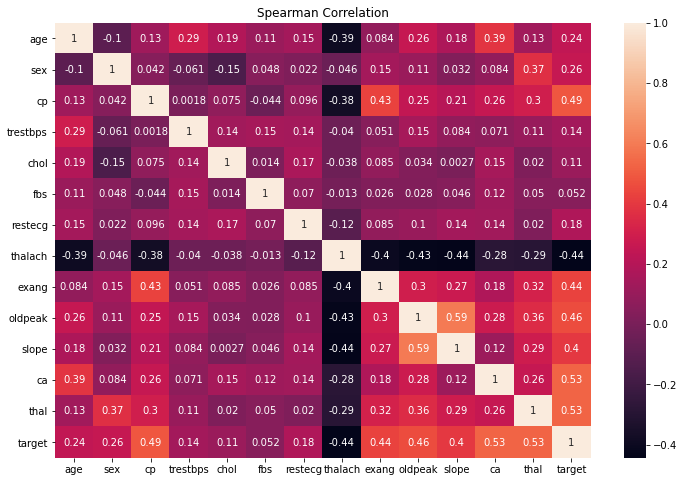

In [6]:
heatmap_cor(dataset,"Spearman Correlation", 'spearman')

## Thal

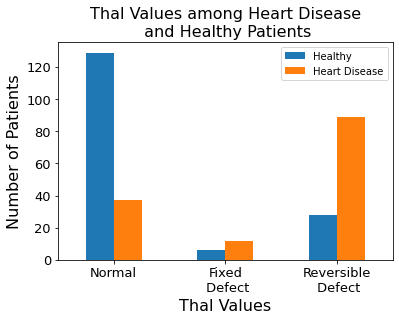

In [7]:
hd_thal = [len(heart_disease[(heart_disease["thal"] == i)]) for i in (3,6,7)]
healthy_thal = [len(healthy[(healthy["thal"] == i)]) for i in (3,6,7)]

df = pd.DataFrame({"Healthy":healthy_thal,"Heart Disease":hd_thal}, index = ["Normal","Fixed\n Defect", "Reversible\n Defect"], columns = ['Healthy','Heart Disease'])
ax = df.plot(kind = "bar",fontsize = 13,rot = 0)

plt.xlabel("Thal Values",size = 16)
plt.ylabel("Number of Patients", size = 16)
plt.title("Thal Values among Heart Disease\n and Healthy Patients", size = 16)
# plt.savefig(fname = "Thal_fig.png")

## ca

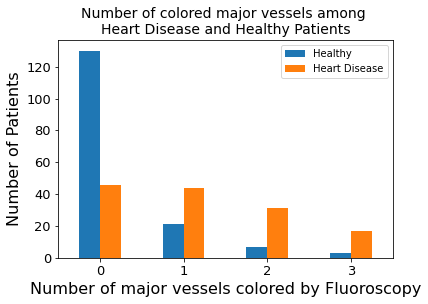

In [8]:
hd_ca = [len(heart_disease[(heart_disease["ca"] == i)]) for i in range(4)]
healthy_ca = [len(healthy[(healthy["ca"] == i)]) for i in range(4)]

df = pd.DataFrame({"Healthy":healthy_ca,"Heart Disease":hd_ca,}, index = list(range(4)), columns = ['Healthy','Heart Disease'])
ax = df.plot(kind = "bar",fontsize = 13 ,rot = 0)


plt.xlabel("Number of major vessels colored by Fluoroscopy",size = 16)
plt.ylabel("Number of Patients", size = 16)
plt.title("Number of colored major vessels among \nHeart Disease and Healthy Patients", size = 14)
# plt.savefig(fname = "ca_fig.png")


## Cholesterol
Desireable < 200 mg/dl
Border Line High - 200-239 mg/dl
High - 240+ mg/dl
<br>
For further information 
[check here](https://www.mayoclinic.org/tests-procedures/cholesterol-test/about/pac-20384601)

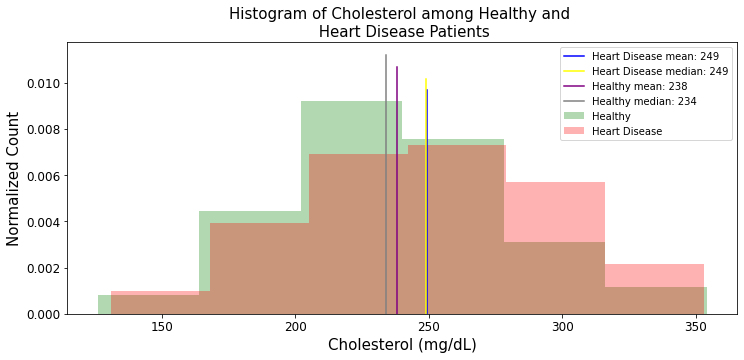

In [9]:

# Removing Outliers
hd_chol, healthy_chol = outliers(heart_disease,"chol",[25,75]), outliers(healthy,"chol",[25,75])

hd_chol = hd_chol["chol"]
healthy_chol = healthy_chol["chol"]
# Mean and Median
hd_mean = hd_chol.mean()
hd_median = hd_chol.median()

healthy_mean = healthy_chol.mean()
healthy_median = healthy_chol.median()

# Figure
fig = plt.figure(figsize=(12,5))

# Hist - Thalach among healthy with exang
plt.hist(healthy_chol, bins = 6, color = "green", density = True, alpha = 0.3, label = "Healthy")

# Hist - Thalach among heart disease with exang
plt.hist(hd_chol, bins = 6, color = "red", density = True, alpha = 0.3, label = "Heart Disease")

# Plot 
# heart Disease mean and median
plt.plot([hd_mean, hd_mean], plt.ylim(), color = "blue", label = "Heart Disease mean: "+str(round(hd_mean)))
plt.plot([hd_median, hd_median], plt.ylim(), color = "yellow", label = "Heart Disease median: "+str(round(hd_median)))

# heart Disease mean and median
plt.plot([healthy_mean, healthy_mean], plt.ylim(), color = "purple", label = "Healthy mean: "+str(round(healthy_mean)))
plt.plot([healthy_median, healthy_median], plt.ylim(), color = "Grey", label = "Healthy median: "+str(round(healthy_median)))


plt.ylabel("Normalized Count",fontdict={"fontsize":15, "fontweight":2})
plt.title("Histogram of Cholesterol among Healthy and \n Heart Disease Patients", 
          fontdict={"fontsize":15, "fontweight":2})
plt.xlabel("Cholesterol (mg/dL)", fontsize = 15)
plt.tick_params(axis = "both", labelsize = 'large')
plt.legend()

## Fasting Blood Sugar

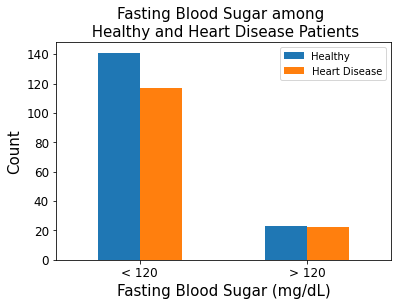

In [10]:
hd_fbs = [len(heart_disease[(heart_disease["fbs"] == i)]) for i in range(2)]
healthy_fbs = [len(healthy[(healthy["fbs"] == i)]) for i in range(2)]

df = pd.DataFrame({"Healthy":healthy_fbs,"Heart Disease":hd_fbs,}, index = ["< 120", "> 120"], columns = ['Healthy','Heart Disease'])
ax = df.plot(kind = "bar", 
             title = "Fasting Blood Sugar among \n Healthy and Heart Disease Patients",
             ylabel = "Count",
             xlabel = "Values",
             rot = 0)


plt.ylabel("Count",fontdict={"fontsize":15, "fontweight":2})
plt.title("Fasting Blood Sugar among \n Healthy and Heart Disease Patients", 
          fontdict={"fontsize":15, "fontweight":2})
plt.xlabel("Fasting Blood Sugar (mg/dL)", fontsize = 15)
plt.tick_params(axis = "both", labelsize = 'large')
plt.legend()

## Exercise Induced Angina \& Thalach among Heart Disease Patients

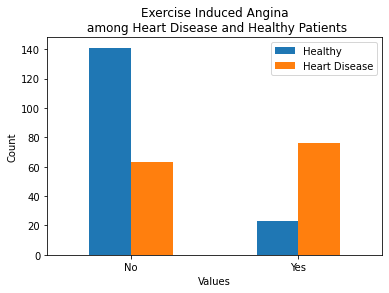

In [11]:
hd_exang = [len(heart_disease[(heart_disease["exang"] == i)]) for i in range(2)]
healthy_exang = [len(healthy[(healthy["exang"] == i)]) for i in range(2)]
df = pd.DataFrame({"Healthy":healthy_exang,"Heart Disease":hd_exang,}, index = ["No", "Yes"], columns = ['Healthy','Heart Disease'])
ax = df.plot(kind = "bar", 
             title = "Exercise Induced Angina\n among Heart Disease and Healthy Patients",
             ylabel = "Count",
             xlabel = "Values",
             rot = 0)

Above 140 Thalach:
Healthy: 65.22%
Heart Disease: 24.00%


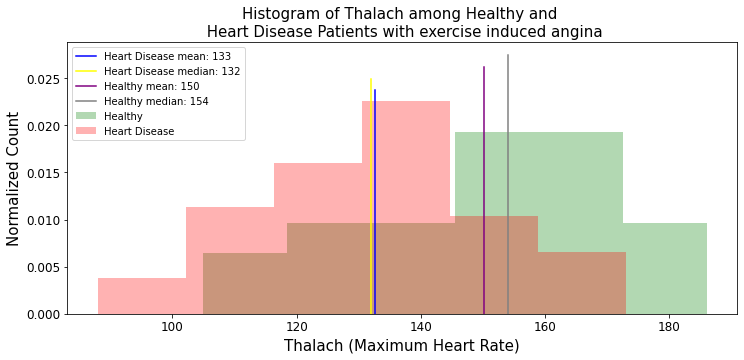

In [12]:
hd_exang = heart_disease[heart_disease["exang"] == 1]
healthy_exang = healthy[healthy["exang"] == 1]

# Removing Outliers
hd_exang, healthy_exang = outliers(hd_exang,"thalach",[25,75]), outliers(healthy_exang,"thalach",[25,75])

# Mean and Median
hd_mean = hd_exang["thalach"].mean()
hd_median = hd_exang["thalach"].median()

healthy_mean = healthy_exang["thalach"].mean()
healthy_median = healthy_exang["thalach"].median()

# Figure
fig = plt.figure(figsize=(12,5))

# Hist - Thalach among healthy with exang
h_hist, h_bins,_= plt.hist(healthy_exang["thalach"], bins = 6, color = "green", density = True, alpha = 0.3, label = "Healthy")

# Hist - Thalach among heart disease with exang
hd_hist, hd_bins,_ = plt.hist(hd_exang["thalach"], bins = 6, color = "red", density = True, alpha = 0.3, label = "Heart Disease")

# Plot 
# heart Disease mean and median
plt.plot([hd_mean, hd_mean], plt.ylim(), color = "blue", label = "Heart Disease mean: "+str(round(hd_mean)))
plt.plot([hd_median, hd_median], plt.ylim(), color = "yellow", label = "Heart Disease median: "+str(round(hd_median)))

# heart Disease mean and median
plt.plot([healthy_mean, healthy_mean], plt.ylim(), color = "purple", label = "Healthy mean: "+str(round(healthy_mean)))
plt.plot([healthy_median, healthy_median], plt.ylim(), color = "Grey", label = "Healthy median: "+str(round(healthy_median)))


plt.ylabel("Normalized Count",fontdict={"fontsize":15, "fontweight":2})
plt.title("Histogram of Thalach among Healthy and \n Heart Disease Patients with exercise induced angina", 
          fontdict={"fontsize":15, "fontweight":2})
plt.xlabel("Thalach (Maximum Heart Rate)", fontsize = 15)
plt.tick_params(axis = "both", labelsize = 'large')
plt.legend()


# Percentage above 140 thalach:
hd_per = sum([hd * (hd_bins[1] - hd_bins[0]) for hd,bin in zip(hd_hist,hd_bins) if bin > 140])*100
h_per = sum([h * (h_bins[1] - h_bins[0]) for h,bin in zip(h_hist,h_bins) if bin > 140])*100

print("Above 140 Thalach:")
print("Healthy: {0:.2f}%".format(h_per))
print("Heart Disease: {0:.2f}%".format(hd_per))


## restecg \& trestbps (Resting Blood Pressure)

Text(0.5, 1.0, 'Resting Electrocardiographic Results \namong Heart Disease and Healthy Patients')

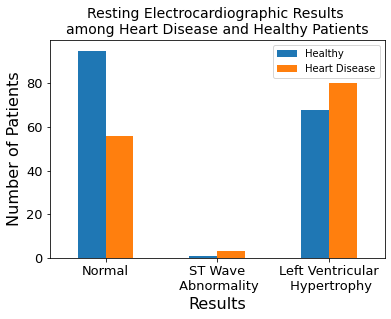

In [13]:
hd_restecg = [len(heart_disease[heart_disease["restecg"] == i]) for i in range(3)]
healthy_restecg = [len(healthy[healthy["restecg"] == i]) for i in range(3)]
df = pd.DataFrame({"Healthy":healthy_restecg,"Heart Disease":hd_restecg,}, index = ["Normal", "ST Wave\n Abnormality", "Left Ventricular\n Hypertrophy"], columns = ['Healthy','Heart Disease'])
ax = df.plot(kind = "bar", 
             fontsize = 13,
             rot = 0)


plt.xlabel("Results",size = 16)
plt.ylabel("Number of Patients", size = 16)
plt.title("Resting Electrocardiographic Results \namong Heart Disease and Healthy Patients", size = 14)
# plt.savefig(fname = "restecg_fig.png")


# Left Ventricular Hypertrophy - High blood pressure

# Machine Learning

## Model \#1 - Logistic Regression

In [14]:
# Baseline --- predict all age >= 50, sex = 1 (males)
cdataset = dataset.copy()
clean_data(cdataset)
y = cdataset["target"]
baseline = ((cdataset["age"] >= 50) & (cdataset["sex"] == 1)).astype(int)

print("Precision: {0:.3f}".format(precision_score(baseline, y)))
print("Recall: {0:.3f}".format(recall_score(baseline,y)))
print("F1: {0:.3f}".format(f1_score(baseline, y)))

Precision: 0.642
Recall: 0.629
F1: 0.635


In [15]:
# Model #1 with discretized Thalach (Maximum Heart Rate Percent)
# Copy dataset
cdataset = dataset.copy()

# Create Pipline with logistic regression classifier
logistic_classifier = Pipeline([('clean', clean_data(cdataset)),
                                ('disc', discretize(cdataset,"oldpeak",1)),
                                ('mhrp',max_HR_percent(cdataset, 85)),
                                ('clf', LogisticRegression(solver='lbfgs'))])

# Target Value
y = cdataset["target"].copy()

# Chosen attributes for the machine learning
x = cdataset[["cp",'exang', 'oldpeak','slope', 'ca','thal',"MHRPercent"]]

# Split data to training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=42)

# Fit logistic classifier to our training data
logistic_classifier.fit(x_train, y_train)

# Make predictions on test data based on the fit
predictions = logistic_classifier.predict(x_test)

# Print Results
print("Results")
print("Precision: {0:.3f}".format(precision_score(predictions, y_test)))
print("Recall: {0:.3f}".format(recall_score(predictions,y_test)))
print("F1: {0:.3f}".format(f1_score(predictions, y_test)))



Results
Precision: 0.848
Recall: 0.933
F1: 0.889


In [16]:
# Try different thresholds to get the best results
for i in range(1,10):

    l = [1 if prediction[1] > i/10 else 0 for prediction in logistic_classifier.predict_proba(x_test)]
    print(f"Threshold: {i/10}")
    print("Precision, recall, and F1 were:")
    print(precision_score(l, y_test))
    print(recall_score(l, y_test))
    print(f1_score(l, y_test))  
    print("")


# Best case is 0.5, let try a closer look
for i in range(35,45):

    l = [1 if prediction[1] > i/100 else 0 for prediction in logistic_classifier.predict_proba(x_test)]
    print(f"Threshold: {i/100}")
    print("Precision, recall, and F1 were:")
    print(precision_score(l, y_test))
    print(recall_score(l, y_test))
    print(f1_score(l, y_test))  
    print("")

# 0.5 is still the best case 


Threshold: 0.1
Precision, recall, and F1 were:
1.0
0.559322033898305
0.717391304347826

Threshold: 0.2
Precision, recall, and F1 were:
0.9393939393939394
0.7045454545454546
0.8051948051948052

Threshold: 0.3
Precision, recall, and F1 were:
0.9090909090909091
0.7692307692307693
0.8333333333333333

Threshold: 0.4
Precision, recall, and F1 were:
0.8787878787878788
0.8529411764705882
0.8656716417910447

Threshold: 0.5
Precision, recall, and F1 were:
0.8484848484848485
0.9333333333333333
0.888888888888889

Threshold: 0.6
Precision, recall, and F1 were:
0.7878787878787878
0.9629629629629629
0.8666666666666665

Threshold: 0.7
Precision, recall, and F1 were:
0.7272727272727273
1.0
0.8421052631578948

Threshold: 0.8
Precision, recall, and F1 were:
0.5151515151515151
1.0
0.6799999999999999

Threshold: 0.9
Precision, recall, and F1 were:
0.36363636363636365
1.0
0.5333333333333333

Threshold: 0.35
Precision, recall, and F1 were:
0.9090909090909091
0.8333333333333334
0.8695652173913043

Threshold: 

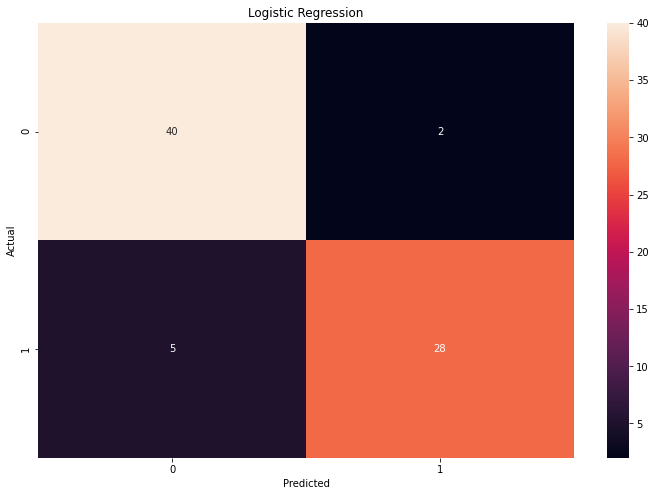

In [17]:
plot_confusion_matrix(y_test,logistic_classifier.predict(x_test), 'Logistic Regression')

## Model 2 - Random Forest

### Import Data

In [18]:
rawdata = pd.read_csv('./data/heart_disease_uci.csv')
rawdata.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
5,56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
6,62,0,4,140,268,0,2,160,0,3.6,3,2,3,3
7,57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
8,63,1,4,130,254,0,2,147,0,1.4,2,1,7,2
9,53,1,4,140,203,1,2,155,1,3.1,3,0,7,1


### Pearson Correlation Heat Map

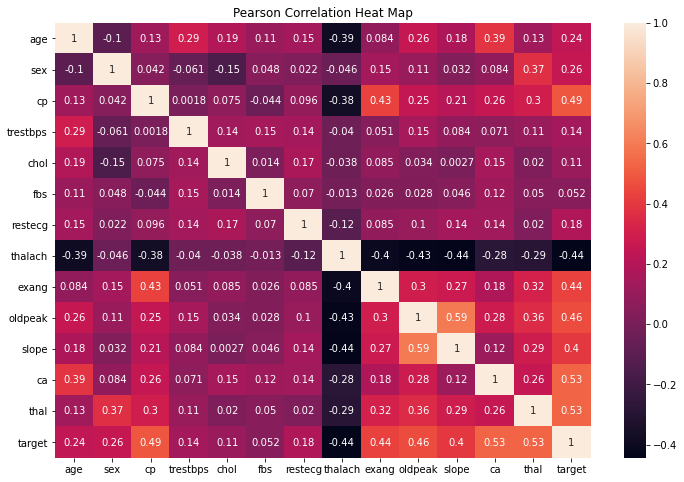

In [19]:
heatmap_cor(rawdata,'Pearson Correlation Heat Map')

### PCA

In [20]:
## Separate the target and the features
features = list(rawdata.columns.values)
x = rawdata.loc[:,features[0:-1]].values
y = rawdata.loc[:,features[-1]].values

## Pre processing the data for PCA

x = StandardScaler().fit_transform(x)

## PCA Projection to 2D

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
pcaData = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

FinishedDF = pd.concat([pcaData,rawdata[[features[-1]]]],axis = 1)


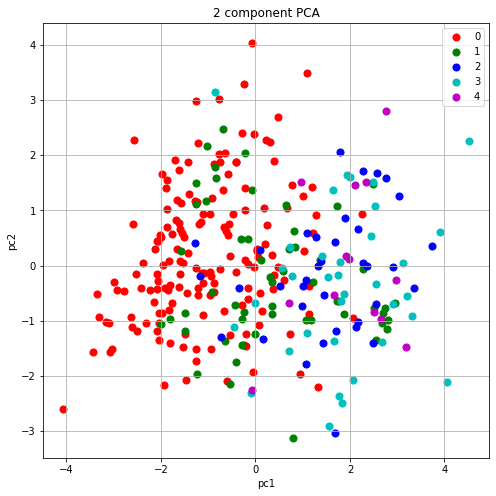

In [21]:
## pca Plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('pc2')
ax.set_xlabel('pc1')
ax.set_title('2 component PCA')
targets = [0,1,2,3,4]
colors = ['r','g','b','c','m']

for target, color in zip(targets,colors):
    indices = FinishedDF[features[-1]] == target
    ax.scatter(FinishedDF.loc[indices, 'pc1']
                ,FinishedDF.loc[indices, 'pc2']
                ,c = color
                ,s = 50)

ax.legend(targets)
ax.grid()

### Reshape Target

In [22]:
for i in range(0,len(rawdata)):
    if rawdata.iloc[i,-1] > 0: rawdata.iloc[i,-1] = 1

### Recreate PCA Graph

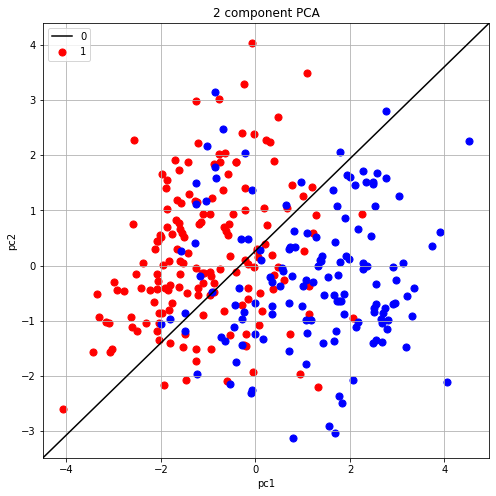

In [23]:
FinishedDF_simple = pd.concat([pcaData,rawdata[[features[-1]]]],axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('pc2')
ax.set_xlabel('pc1')
ax.set_title('2 component PCA')
targets = [0,1]
colors = ['r','b']

for target, color in zip(targets,colors):
    indices = FinishedDF_simple[features[-1]] == target
    ax.scatter(FinishedDF_simple.loc[indices, 'pc1']
                ,FinishedDF_simple.loc[indices, 'pc2']
                ,c = color
                ,s = 50)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, c = 'black')
ax.legend(targets)
ax.grid()

### Heatmap based on reshaped data

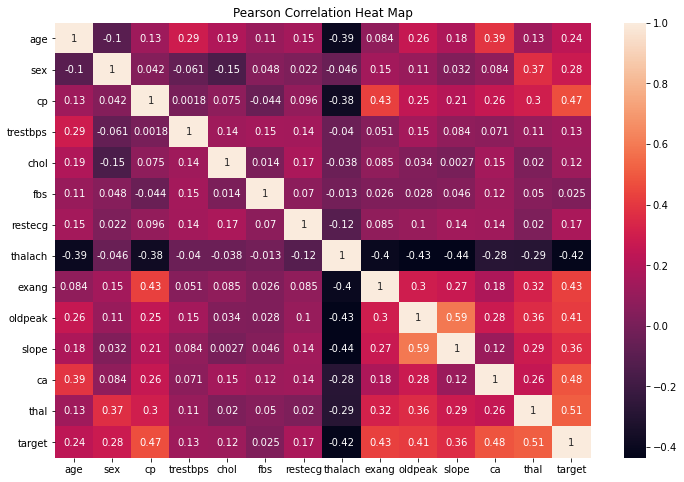

In [24]:
heatmap_cor(rawdata,'Pearson Correlation Heat Map')

### Train Test Split

In [25]:
x = rawdata[["cp",'exang', 'oldpeak','thal']] # Most important features according to the pearson heatmap
y = rawdata["target"]

x_train,x_test,y_train,y_test = ml_train_test_split(x, y, size = 0.25)

### Random Forrest

In [26]:
# With 500 estimators
# rawdata
model,x_test,y_test = run_random_forest(x_train,x_test,y_train,y_test, 500)
print("The score for estimator 500 and a 25% test set is {:.5f}".format(model.score(x_test,y_test)))
# With 100 estimators
# rawdata
model,x_test,y_test = run_random_forest(x_train,x_test,y_train,y_test, 100)
print("The score for estimator 100 and a 25% test set is {:.5f}".format(model.score(x_test,y_test)))
# With 50 estimators
# rawdata
model,x_test,y_test = run_random_forest( x_train,x_test,y_train,y_test, 50)
print("The score for estimator 50 and a 25% test set is {:.5f}".format(model.score(x_test,y_test)))


The score for estimator 500 and a 25% test set is 0.82895
The score for estimator 100 and a 25% test set is 0.81579
The score for estimator 50 and a 25% test set is 0.82895


In [27]:
print("Precision: {0:.3f}".format(precision_score(model.predict(x_test), y_test)))
print("Recall: {0:.3f}".format(recall_score(model.predict(x_test),y_test)))
print("F1: {0:.3f}".format(f1_score(model.predict(x_test), y_test)))

Precision: 0.811
Recall: 0.833
F1: 0.822


### Confusion Matrix

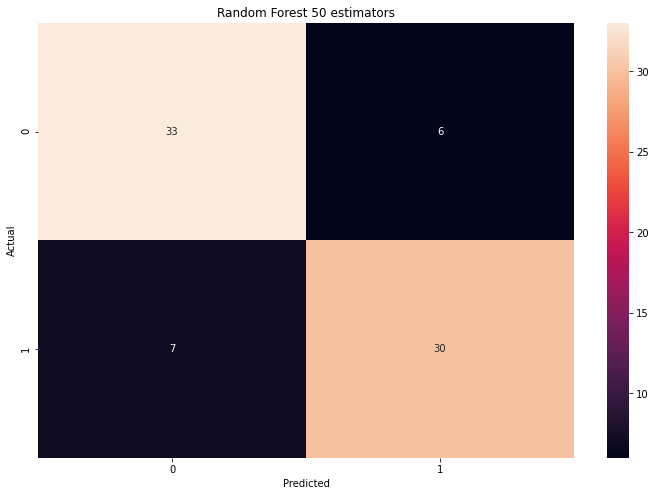

In [28]:
plot_confusion_matrix(y_test,model.predict(x_test),'Random Forest 50 estimators')